# An Overview of Qiskit Nature
<br/>
<br/>
<br/>
<br/>
<br/>
Pauline J. Ollitrault<br/>
IBM Quantum, IBM Research Zürich

Qiskit Nature is the application module dealing with problems in **natural sciences**.
Its goal is to provide end-user oriented modules which enable the fast solution of problems in _chemistry_, _physics_ and _biology_.

Chemistry problems are of particular interest because they are a natural simulation target for quantum computing.

Nature currently provides the following modules:

<img src="images/overview.png" width="1400"/>

In general, any application is split into **Problems** and **Solvers** which are combined like so:
<img src="images/Nature_YT_Workflow.svg"/>
> or in terms of code: `result = solver.solve(problem)`

This modular approach permits the reusability of a solver for multiple problems.

Depending on your actual application, the internals of your problem can take different forms.
For example, the `ElectronicStructureProblem` looks like this:
<img src="images/Nature_YT_ElectronicStructureProblem.svg"/>

A similar modularity exists for the solvers. Generally these are provided by the `qiskit_nature.algorihtms` module which provide convenient wrappers of the actual algorithms implement in Qiskit Terra.
Here is an example of the `GroundStateEigensolver`:
<img src="images/Nature_YT_GroundStateEigensolver.svg"/>

In [1]:
import warnings

from h5py.h5py_warnings import H5pyDeprecationWarning
from sympy.utilities.exceptions import SymPyDeprecationWarning

warnings.filterwarnings(action="ignore", category=H5pyDeprecationWarning)
warnings.filterwarnings(action="ignore", category=SymPyDeprecationWarning)

## 1. Electronic Structure Hamiltonian

See also: https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html

The `ElectronicStructureProblem` makes it easy for us to represent a problem in the second quantization form.
As an input, this kind of problem takes a so called `Driver` which is a concept in Qiskit Nature that allows us to couple to other (classical) computational chemistry codes which compute the 1- and 2-body integrals for us.

As a simple example, we will be using the generic `Molecule`-based interface and tell it to use `PySCF` as the classical computational backend.

In [2]:
from qiskit_nature.drivers import Molecule

molecule = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["Li", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, 1.6]],
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

In [3]:
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

We could now run the driver manually by calling `driver.run()` but the preferred way is to wrap it into the previously mentioned `ElectronicStructureProblem` which we can solve later on.

In [4]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

problem = ElectronicStructureProblem(driver)

Out of curiosity let us inspect the Hamiltonian of our system in its second-quantized form:

In [5]:
# this will call driver.run() internally
second_q_ops = problem.second_q_ops()

In [6]:
from qiskit_nature.operators.second_quantization import FermionicOp

# we increase the truncation value of the FermionicOp applied while printing
FermionicOp.set_truncation(500)

In [7]:
hamiltonian = second_q_ops[0]
print(hamiltonian)

Fermionic Operator
register length=12, number terms=630
  (0.0011296372513019074+0j) * ( +_0 +_1 -_2 -_5 )
+ (-0.005356076256879888+0j) * ( +_0 -_1 +_2 -_5 )
+ (0.004226439005578+0j) * ( +_0 -_1 -_2 +_5 )
+ (0.013337578188187121+0j) * ( +_0 -_1 +_6 -_7 )
+ (0.011215774496185375+0j) * ( +_0 -_1 +_6 -_8 )
+ (-0.008906674605061742+0j) * ( +_0 -_1 +_6 -_11 )
+ (-0.013337578188187106+0j) * ( +_0 -_1 -_6 +_7 )
+ (-0.011215774496185361+0j) * ( +_0 -_1 -_6 +_8 )
+ (0.00890667460506174+0j) * ( +_0 -_1 -_6 +_11 )
+ (-0.003349390720902146+0j) * ( +_0 -_1 +_ ...


We can gain further insight by investigating the raw output of our driver (see also: https://qiskit.org/documentation/nature/tutorials/08_property_framework.html):

In [8]:
print(problem.grouped_property)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 1.7.6
		Config:
			atom=Li 0.0 0.0 0.0;H 0.0 0.0 1.6
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9912505281384083
		[0, 1] = -0.16708957810826783
		[0, 2] = -0.21004274416106097
		[0, 3] = 3.183872705625983e-17
		[0, 4] = -3.3354922330541735e-17
		[0, 5] = 0.09345849809002903
		[1, 0] = 0.032706585262515575
		[1, 1] = 0.45524436150203706
		[1, 2] = 0.7995433555171559
		[1, 3] = -1.5907840172738894e-16
		[1, 4] = 1.5629201017731932e-16
		[1, 5] = -0.7026838049076962
		[2, 0] = 9.911223768815312e-19
		[2, 1] = -1.9645135300508828e-16
		[2, 2] = 3.2842484045142025e-17
		[2, 3] = 0.280650214962163
		[2, 4] = 0.9598101149923837
		[2, 5] = -6.867909053414926e-18
		[3, 0] = -1.3113514023274476e-20
		[3, 1] =

<div style="float: left; width: 50%;">
    We can reduce the size of our problem by selected a subset of orbitals to be treated with the quantum algorithm. This concept is known as an <b>active space</b>.
</div>
<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/active_space.png" width="600"/>
</div>

Qiskit Nature provides the generic `ActiveSpaceTransformer` to apply such a reduction:

In [9]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer

transformer = ActiveSpaceTransformer(
    num_electrons=2,
    num_molecular_orbitals=3,
)

In [10]:
problem_reduced = ElectronicStructureProblem(driver, [transformer])
second_q_ops_reduced = problem_reduced.second_q_ops()
hamiltonian_reduced = second_q_ops_reduced[0]

In [11]:
print(hamiltonian_reduced)

Fermionic Operator
register length=6, number terms=61
  (0.013063981998647733+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.013063981998647747+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.04857959952050992+0j) * ( +_0 -_1 )
+ (0.005767502046081511+0j) * ( +_0 -_1 +_5 -_5 )
+ (0.007484171005675162+0j) * ( +_0 -_1 +_4 -_4 )
+ (-0.048579588912290195+0j) * ( +_0 -_1 +_3 -_3 )
+ (-0.01350939040244916+0j) * ( +_0 -_1 +_2 -_2 )
+ (0.023422673239778494+0j) * ( +_0 -_2 +_3 -_5 )
+ (-0.023422673239778494+0j) * ( +_0 -_2 -_3 +_5 )
+ (0.019276892448530668+0j) * ( +_0 -_2 +_4 -_5 )
+  ...


In [12]:
print(problem_reduced.grouped_property_transformed)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 1.7.6
		Config:
			atom=Li 0.0 0.0 0.0;H 0.0 0.0 1.6
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.9912505281384083
		[0, 1] = -0.16708957810826783
		[0, 2] = -0.21004274416106097
		[0, 3] = 3.183872705625983e-17
		[0, 4] = -3.3354922330541735e-17
		[0, 5] = 0.09345849809002903
		[1, 0] = 0.032706585262515575
		[1, 1] = 0.45524436150203706
		[1, 2] = 0.7995433555171559
		[1, 3] = -1.5907840172738894e-16
		[1, 4] = 1.5629201017731932e-16
		[1, 5] = -0.7026838049076962
		[2, 0] = 9.911223768815312e-19
		[2, 1] = -1.9645135300508828e-16
		[2, 2] = 3.2842484045142025e-17
		[2, 3] = 0.280650214962163
		[2, 4] = 0.9598101149923837
		[2, 5] = -6.867909053414926e-18
		[3, 0] = -1.3113514023274476e-20
		[3, 1] =

### Mapping the Problem to the Qubit Space

In order to solve our problem with a Quantum algorithm we must map our second-quantized Hamiltonian into a qubit operator. This is done with the `QubitConverter` in combination with a `QubitMapper` of your choice.

Each MO can hold up to two electrons, one spin-up (_alpha_) and one spin-down (_beta_) electron.

In Qiskit we will need to map these two cases onto the quantum computer separately. Thus, we are working with **spin orbitals** which are identical to the MOs but restrict the spin in either the up or down configuration, depending on the nature of the orbital.

The most straight forward mapping is the *Jordan-Wigner* one which stores the *occupation* information of one spin orbital in one qubit:

<img src="images/jw_mapping.png" width="1400"/>

In [13]:
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper

jw_mapper = JordanWignerMapper()
jw_converter = QubitConverter(jw_mapper)

In [14]:
qubit_op_jw = jw_converter.convert(hamiltonian_reduced)
print(qubit_op_jw)

-0.4600743351528299 * IIIIII
- 0.1616534714987323 * ZIIIII
- 0.14571632129552559 * IZIIII
+ 0.06017866224139638 * ZZIIII
+ 0.026694013979351366 * IIZIII
+ 0.06168720475907274 * ZIZIII
+ 0.05263651528550088 * IZZIII
- 0.1616534714987323 * IIIZII
+ 0.07823637778985225 * ZIIZII
+ 0.07049783624066804 * IZIZII
+ 0.06754287306901736 * IIZZII
- 0.1457163212955256 * IIIIZI
+ 0.07049783624066804 * ZIIIZI
+ 0.08447056807294419 * IZIIZI
+ 0.055902510785162826 * IIZIZI
+ 0.06017866224139638 * IIIZZI
+ 0.026694013979351342 * IIIIIZ
+ 0.06754287306901736 * ZIIIIZ
+ 0.055902510785162826 * IZIIIZ
+ 0.12182774215821074 * IIZIIZ
+ 0.06168720475907274 * IIIZIZ
+ 0.05263651528550088 * IIIIZZ
+ 0.012080473194509313 * IXXIII
+ 0.0033773476006122892 * ZXXIII
+ 0.012080473194509313 * IYYIII
+ 0.0033773476006122892 * ZYYIII
- 0.001441875511520379 * IXXZII
- 0.001441875511520379 * IYYZII
- 0.001871042751418799 * IXXIZI
- 0.001871042751418799 * IYYIZI
+ 0.012144897228072542 * IXXIIZ
+ 0.012144897228072542 * IYYI

In this step we can reduce the size of our problem further by leveraging symmetries in the Hilbert space of our system. One mapping which supports a straight-forward removal of 2 qubits by exploiting the particle-conserving properties of electronic structure problems, is the *parity* mapping:

In [15]:
from qiskit_nature.mappers.second_quantization import ParityMapper

parity_mapper = ParityMapper()
parity_converter = QubitConverter(parity_mapper, two_qubit_reduction=True)

In [16]:
qubit_op_parity = parity_converter.convert(hamiltonian_reduced, num_particles=problem_reduced.num_particles)
print(qubit_op_parity)

-0.46007433515282975 * IIII
+ (-0.21428998678423308+6.938893903907228e-18j) * ZIII
+ (0.03348464826204499-5.204170427930421e-18j) * IZII
- 0.20740352605459828 * ZZII
+ (0.21428998678423308+1.3877787807814457e-17j) * IIZI
- 0.07823637778985222 * ZIZI
+ 0.06754287306901734 * IZZI
+ (-0.07049783624066801+6.938893903907228e-18j) * ZZZI
- 0.033484648262045016 * IIIZ
+ 0.06754287306901734 * ZIIZ
+ (-0.12182774215821071-6.938893903907228e-18j) * IZIZ
+ 0.055902510785162805 * ZZIZ
+ (-0.2074035260545983+6.938893903907228e-18j) * IIZZ
+ 0.07049783624066801 * ZIZZ
+ (-0.055902510785162805+3.469446951953614e-18j) * IZZZ
+ 0.08447056807294416 * ZZZZ
+ 0.015457820795121594 * IXII
+ (0.015457820795121594+8.673617379884035e-19j) * ZXII
+ (0.0014418755115203784-1.0842021724855044e-19j) * IXZI
+ 0.0014418755115203784 * ZXZI
+ 0.012144897228072537 * IXIZ
+ (0.012144897228072537+8.673617379884035e-19j) * ZXIZ
- 0.0018710427514187981 * IXZZ
+ (-0.0018710427514187981+1.0842021724855044e-19j) * ZXZZ
+ 0.010

## 2. Ground State Calculation

<div style="float: left; width: 50%;">
Now that we have converted our problem to a Qubit operator, we need to find it's eigenvalue which corresponds to the ground state of our system.
    <br/>
    <br/>
    See also: https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html
</div>

<div style="float: right; width: 50%; padding-right=20px;">
    <img src="images/H2_gs.png" width="400"/>
    <br>
</div>

To find the ground state we need an *Ansatz* to describe our wavefunction:

In [17]:
particle_number = problem_reduced.grouped_property_transformed.get_property("ParticleNumber")
num_spin_orbitals = particle_number.num_spin_orbitals
num_particles = particle_number.num_particles

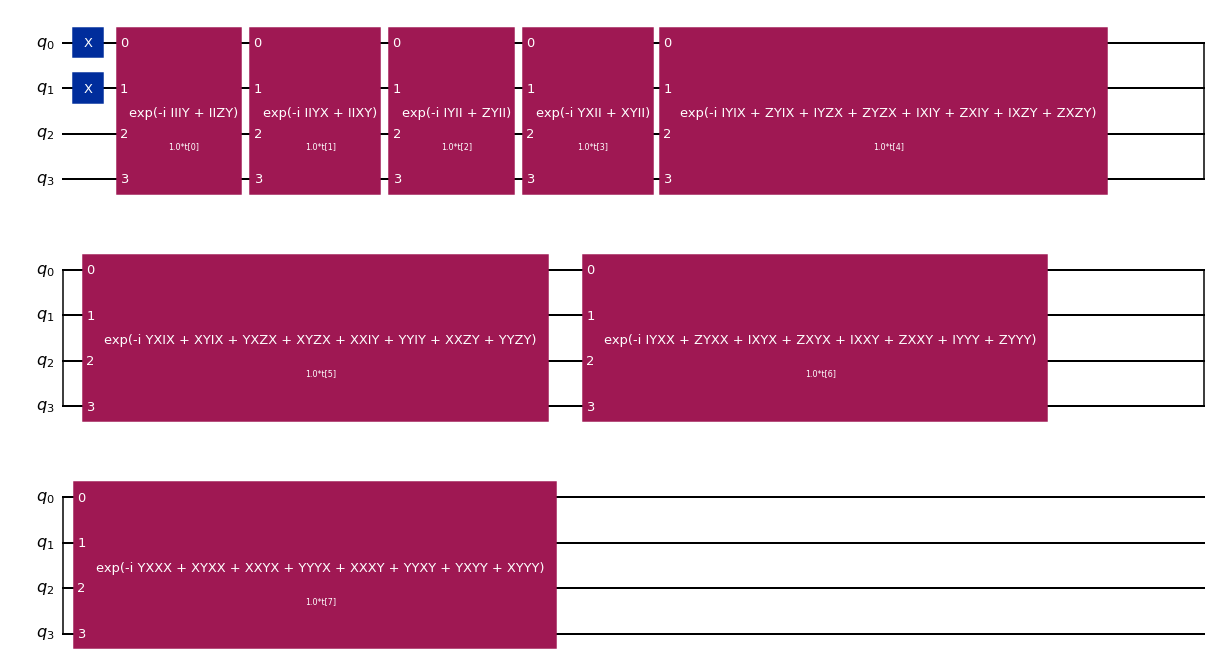

In [18]:
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit_nature.circuit.library.ansatzes import UCCSD

init_state = HartreeFock(num_spin_orbitals, num_particles, parity_converter)

ansatz = UCCSD(
    parity_converter,
    num_particles,
    num_spin_orbitals,
)
ansatz.initial_state = init_state

ansatz.decompose().draw('mpl', style='iqx')

Since this is quite some overhead which even involves knowing the number of particles beforehand, we provide a **factory** for the `VQE`, simplifying its construction a lot:

In [19]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.providers.aer import StatevectorSimulator, QasmSimulator
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import VQEUCCFactory

# this will setup the UCCSD + HartreeFock Ansatz internally at runtime
vqe_factory = VQEUCCFactory(
    quantum_instance=StatevectorSimulator(),
    #quantum_instance=QasmSimulator(),
    optimizer=SLSQP(),
)

This factory can then be used to construct a `GroundStateEigensolver` with which we can finally solve our problem:

In [20]:
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver

solver = GroundStateEigensolver(parity_converter, vqe_factory)

In [21]:
result = solver.solve(problem_reduced)

In [22]:
print(result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.855126562343
  - computed part:      -1.058906993571
  - ActiveSpaceTransformer extracted energy part: -7.796219568771
~ Nuclear repulsion energy (Hartree): 0.992207270475
> Total ground state energy (Hartree): -7.862919291868
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  3.0235618]
 
  0: 
  * Electronic dipole moment (a.u.): [0.00000009  0.00000029  4.90825164]
    - computed part:      [0.00000009  0.00000029  4.91230356]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  -0.00405191]
  > Dipole moment (a.u.): [-0.00000009  -0.00000029  -1.88468984]  Total: 1.88468984
                 (debye): [-0.00000022  -0.00000075  -4.79040331]  Total: 4.79040331
 


#### CUSTOM VQE

In [75]:
import numpy as np
from qiskit import transpile
from qiskit.algorithms import MinimumEigensolver, VQEResult
from qiskit.opflow import PauliSumOp, AbelianGrouper
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

qasm_backend = QasmSimulator(shots=8192)
backend = qasm_backend


def raw_sample(circuit, backend=backend, optimization_level=3):
    
    # transpile circuit
    qc = transpile(circuit, backend, optimization_level=optimization_level)
    
    # run circuit
    job = backend.run(qc)
    counts = job.result().get_counts()
    
    # evaluate probabilities
    shots = sum(counts.values())
    probabilities = {b: c/shots for b, c in counts.items()}
    return probabilities

sample = raw_sample

class Estimator():
    
    def __init__(self, observable, circuit, callback=None):
        """ Instantiate estimator for given observable and circuit. """
        
        # store problem
        self._observable = observable
        self._circuit = circuit
        
        # group Pauli terms
        self._grouper = AbelianGrouper()
        self._groups = self._grouper.convert(self._observable).oplist
        
        # derive measurement bases
        self._bases = []
        for group in self._groups:
            self._bases += [self._get_measurement_basis(group)]
            
        # construct circuits with post-rotations
        self._circuits = []
        for basis in self._bases:
            self._circuits += [self._append_post_rotation(self._circuit, basis)]
            
        # store callback
        self._callback = callback
        
    def _get_measurement_basis(self, observable):
        """ Derive measurement basis from observable or raise exception in case of non-commuting terms. """
                
        basis = ['I']*observable.num_qubits
        for pauli_string in observable.primitive.paulis:
            for i, pauli in enumerate(pauli_string):
                p = str(pauli)
                if p != 'I':
                    if basis[i] == 'I':
                        basis[i] = p
                    elif basis[i] != p:
                        raise ValueError('PauliSumOp contains non-commuting terms!')
        return basis
    
    def _append_post_rotation(self, circuit, basis):
        """ Append post rotation to circuit to measure in given basis. """
        
        new_circuit = circuit.copy()
        for i, pauli in enumerate(basis):
            if pauli == 'X':  # H @ X @ H = Z
                new_circuit.h(i)
            if pauli == 'Y':  # S^dag @ H @ Y @ H @ S = Z
                new_circuit.s(i)
                new_circuit.h(i)
        new_circuit.measure_all()
        return new_circuit
    
    def estimate(self, param_values=None):
        """ Estimate expectation value of given observable in state corresponding to given parameter values. """

        if param_values is None and self._circuit.num_parameters > 0 or\
            len(param_values) != self._circuit.num_parameters:
            raise ValueError('Wrong number of parameters!')
        
        value = 0        
        for group, circuit in zip(self._groups, self._circuits):
            value += self._estimate_group(group, circuit, param_values)        
            
        if self._callback:
            self._callback(np.real(value))
            
        return np.real(value)
        
    def _estimate_group(self, group, circuit, param_values):
        """ Estimate expectation value for group of commuting terms that can be measured in the same basis. """
        
        probabilities = sample(circuit.bind_parameters(param_values), backend)
        
        value = 0
        for (pauli, coeff) in zip(group.primitive.paulis, group.primitive.coeffs):
            val = 0
            p = str(pauli)
            for b, prob in probabilities.items():
                val += prob * np.prod([(-1)**(b[i] == '1' and p[i] != 'I') for i in range(len(b))])

            value += coeff * val
    
        return value



class CustomVQE(MinimumEigensolver):
    
    def __init__(self, circuit, optimizer):
        self._circuit = circuit
        self._optimizer = optimizer
        
    def compute_minimum_eigenvalue(self, operator, aux_operators=None):
                
        # run optimization
        estimator = Estimator(operator, self._circuit)        
        x0 = np.random.rand(self._circuit.num_parameters)
        res = self._optimizer.minimize(estimator.estimate, x0=x0)

        # evaluate auxilliary operators if given
        aux_operator_eigenvalues = None
        if aux_operators is not None:
            aux_operator_eigenvalues = []
            for aux_estimator in [ Estimator(aux_op, self._circuit) 
                                      for aux_op in aux_operators ]:
                aux_operator_eigenvalues += [aux_estimator.estimate(res.x)]
        
        # populate results
        result = VQEResult()
        result.aux_operator_eigenvalues = aux_operator_eigenvalues
        result.cost_function_evals = res.nfev
        result.eigenstate = None
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        result.optimal_point = res.x
        result.optimal_value = res.fun
        return result

In [76]:
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SPSA

circuit = TwoLocal(qubit_op_parity.num_qubits, ['ry', 'rz'], 'cx', entanglement='full', reps=3)

optimizer = SPSA(maxiter=50)

custom_vqe = CustomVQE(circuit, optimizer)
result = custom_vqe.compute_minimum_eigenvalue(qubit_op_parity)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 100,
    'eigenstate': None,
    'eigenvalue': -1.0303574985296442,
    'optimal_parameters': array([-2.87642435,  3.13160798,  2.3289322 ,  1.67230181, -2.74886228,
       -1.40336111,  2.83335135,  2.94849059, -2.55371391,  0.22856364,
       -1.98611972,  2.47274391,  2.93211843,  0.38021579, -3.23798193,
        3.3945246 ,  2.75822281, -2.77621849, -0.7576953 , -0.52617232,
       -0.45481548,  3.74913133,  3.60806062,  3.11525564,  0.43090445,
        3.07410478, -1.26468665, -1.09979124,  2.60340287,  3.29759672,
        0.32199848,  0.19340552]),
    'optimal_point': array([-2.87642435,  3.13160798,  2.3289322 ,  1.67230181, -2.74886228,
       -1.40336111,  2.83335135,  2.94849059, -2.55371391,  0.22856364,
       -1.98611972,  2.47274391,  2.93211843,  0.38021579, -3.23798193,
        3.3945246 ,  2.75822281, -2.77621849, -0.7576953 , -0.52617232,
       -0.45481548,  3.74913133,  3.60806062,  3.11525564,  0.430

## 2. Excited States Calculation

See also: https://qiskit.org/documentation/nature/tutorials/04_excited_states_solvers.html

Now, we are not only interested in ground states but also excited states! `QEOM` provides the means to compute these states by solving the **equation of motion**. QEOM currently does not support the hamiltonian reductions which we used in combination with the parity mapping. Thus let's look at an example for the hydrogen molecule.

In [77]:
from qiskit_nature.algorithms.excited_states_solvers import QEOM

h2 = Molecule(
    # coordinates are given in Angstrom
    geometry=[
        ["H", [0.0, 0.0, 0.0]],
        ["H", [0.0, 0.0, 0.75]],
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

h2_driver = ElectronicStructureMoleculeDriver(
    molecule=h2,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
)

h2_problem = ElectronicStructureProblem(h2_driver)

jw_solver = GroundStateEigensolver(jw_converter, vqe_factory)

qeom = QEOM(jw_solver, "sd")

In [78]:
qeom_result = qeom.solve(h2_problem)

In [79]:
print(qeom_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.842686681847
  - computed part:      -1.842686681847
~ Nuclear repulsion energy (Hartree): 0.70556961456
> Total ground state energy (Hartree): -1.137117067287
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -1.248353972498
* Electronic excited state energy (Hartree): -1.248353972498
> Total excited state energy (Hartree): -0.542784357938
  2: 
* Electronic excited state energy (Hartree): -0.884810899311
* Electronic excited state energy (Hartree): -0.884810899311
> Total excited state energy (Hartree): -0.179241284751
  3: 
* Electronic excited state energy (Hartree): -0.245767351782
* Electronic excited state energy (Hartree): -0.245767351782
> Total excited state energy (Hartree): 0.459802262778
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.41729459]
 
  0: 

You can also evaluate auxiliary operators on excited states with the `NumPyEigensolver` (which is a classical algorithm to solve the EOM).

In [88]:
from qiskit_nature.algorithms.excited_states_solvers.eigensolver_factories import NumPyEigensolverFactory

def filter_criterion(eigenstate, eigenvalue, aux_values):
    # we only ensure that the number of particles equals 2
    return np.isclose(aux_values[0][0], 2.)

numpy_es_solver = NumPyEigensolverFactory(filter_criterion=filter_criterion)

numpy_es_calculation = ExcitedStatesEigensolver(jw_converter, numpy_es_solver)

This solver can simply be wrapped into an `ExcitedStatesEigensolver`, mirroring the interface of the `GroundStateEigensolver`:

In [89]:
numpy_es_result = numpy_es_calculation.solve(h2_problem)
print(numpy_es_result)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.842686681906
  - computed part:      -1.842686681906
~ Nuclear repulsion energy (Hartree): 0.70556961456
> Total ground state energy (Hartree): -1.137117067346
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -1.248351713418
* Electronic excited state energy (Hartree): -1.248351713418
> Total excited state energy (Hartree): -0.542782098858
  2: 
* Electronic excited state energy (Hartree): -1.248351713418
* Electronic excited state energy (Hartree): -1.248351713418
> Total excited state energy (Hartree): -0.542782098858
  3: 
* Electronic excited state energy (Hartree): -1.248351713418
* Electronic excited state energy (Hartree): -1.248351713418
> Total excited state energy (Hartree): -0.542782098858
  4: 
* Electronic excited state energy (Hartree): -0.884808640263
* Electronic excited state energy (Hartree): -0.884808640263
> Total excited state energy (Hartree): -0.17923

### VQD

In [90]:
from qiskit.algorithms import Eigensolver, EigensolverResult
import time

estimator = Estimator(h2_qubit_op, circuit, lambda x: print(f'objective = {x}'))

# set penalty weight for overlap term
penalty = 40

# define objective for VQD
def vqd_objective(param_values, 
                  energy=estimator.estimate, 
                  overlap=lambda x: fidelity.estimate(x, ground_state_params),
                  penalty=penalty):

    value = energy(param_values)
    value += penalty * overlap(param_values)
    return value


class Fidelity():
    
    def __init__(self, circuit_1, circuit_2, callback=None):
        """ Instantiate fidelity estimator. """
        self._circuit_1 = circuit_1
        self._circuit_2 = circuit_2
        
        self._circuit_1.remove_final_measurements()
        self._circuit_2.remove_final_measurements()
        
        self._callback = callback
        
    def estimate(self, param_values_1, param_values_2):
        """ Estimate fidelity between the two states defined by 
        the given parameter values. """
        
        # bind parameter values and transpile circuit
        qc = self._circuit_1.bind_parameters(param_values_1)
        qc.append(self._circuit_2.bind_parameters(param_values_2).inverse(), 
                  range(self._circuit_2.num_qubits))
        qc.measure_all()
        
        # run circuit and get probabilities
        probabilities = sample(qc, backend)
        
        # estimate fidelity: |<0|U_1^dag U_2|0>|^2
        fidelity = np.maximum(0.0, probabilities.get('0'*qc.num_qubits, 0.0))
        
        if self._callback:
            self._callback(fidelity)
        
        return fidelity
    

class VQD(Eigensolver):
    
    def __init__(self, circuit, optimizer):
        self._circuit = circuit
        self._optimizer = optimizer
        
    def compute_eigenvalues(self, operator, aux_operators=None):
        
        # setup estimators
        estimator = Estimator(operator, self._circuit)
        fidelity = Fidelity(self._circuit, self._circuit)
        
        # compute groundstate
        vqe = CustomVQE(self._circuit, self._optimizer)
        vqe_result = vqe.compute_minimum_eigenvalue(operator)
        
        # compute first excited states
        objective = lambda x: vqd_objective(x, estimator.estimate, 
                                            lambda y: fidelity.estimate(y, vqe_result.optimal_parameters))
        
        x0 = np.random.rand(self._circuit.num_parameters)
        res = self._optimizer.minimize(objective, x0)
                
        # populate results
        result = EigensolverResult()
        result.eigenvalues = [vqe_result.eigenvalue, res.fun]        
        return result        


In [92]:
h2_second_q_ops = h2_problem.second_q_ops()
h2_hamiltonian = h2_second_q_ops[0]
h2_qubit_op = jw_converter.convert(h2_hamiltonian)

h2_particle_number = h2_problem.grouped_property.get_property("ParticleNumber")
h2_num_spin_orbitals = h2_particle_number.num_spin_orbitals
h2_num_particles = h2_particle_number.num_particles

h2_init_state = HartreeFock(h2_num_spin_orbitals, h2_num_particles, jw_converter)

h2_ansatz = UCCSD(
    jw_converter,
    h2_num_particles,
    h2_num_spin_orbitals,
)
h2_ansatz.initial_state = h2_init_state

vqd = VQD(h2_ansatz, optimizer)
result = vqd.compute_eigenvalues(h2_qubit_op)
print(result)


{   'aux_operator_eigenvalues': None,
    'eigenstates': None,
    'eigenvalues': [-1.8408305444540258, -0.9781032525487642]}


## Additional Resources

* Documentation: https://qiskit.org/documentation/nature/
* Tutorials: https://qiskit.org/documentation/nature/tutorials/index.html
* Source code: https://github.com/Qiskit/qiskit-nature

In [66]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

/home/oss/Files/PhD/presentations/IEEE2021/workshop/.direnv/python-3.9.7/lib64/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Qiskit Software,Version
qiskit-terra,0.18.3
qiskit-aer,0.9.1
qiskit-ignis,0.6.0
qiskit-ibmq-provider,0.17.0
qiskit-aqua,0.9.5
qiskit,0.31.0
qiskit-nature,0.2.2
qiskit-finance,0.2.1
qiskit-optimization,0.2.3
qiskit-machine-learning,0.2.1
